### 1、导入相应的模块

In [ ]:
import tensorflow as tf
from tensorflow import keras
from utils import *
import time
import os
from IPython import display

### 2、一些全局变量，因为之后可能需要用到

In [ ]:
''' 

开始训练的一些参数 

'''
EPOCHS = 300
LEARNING_RATE = 0.0002
BATCH_SIZE = 8
SHAPE = [256,256,3]

### 3、数据预处理

In [ ]:
train_input_img_dir='Datasets/train/image/'
train_output_img_dir='Datasets/train/label/'

validation_input_img_dir = 'Datasets/validation/image/'
validation_output_img_dir = 'Datasets/validation/label/'

In [ ]:
train_input_img_path = [os.path.join(train_input_img_dir,img) for img in os.listdir(train_input_img_dir)]
train_output_img_path = [os.path.join(train_output_img_dir,img) for img in os.listdir(train_output_img_dir)]

validation_input_img_path = [os.path.join(validation_input_img_dir,img) for img in os.listdir(validation_input_img_dir)]
validation_output_img_path = [os.path.join(validation_output_img_dir,img) for img in os.listdir(validation_output_img_dir)]

In [ ]:
print(len(train_input_img_path))
print(len(train_output_img_path))
print(len(validation_input_img_path))
print(len(validation_output_img_path))

#### load()函数主要就是将从一个图片转化为一个float32类型的tensor的数据

In [ ]:
def load(input_image_file,output_image_file):
    
    input_image = tf.io.read_file(input_image_file)   # 这边输出的是一个String类型的Tensor
    input_image = tf.image.decode_jpeg(input_image)   # 这边输出的是一个uint8类型的Tensor
    input_image = tf.image.resize(input_image,size=(SHAPE[0],SHAPE[1]))   # 这边输出的是一个float32类型的Tensor
    
    
    output_image = tf.io.read_file(output_image_file)
    output_image = tf.image.decode_jpeg(output_image)
    output_image = tf.image.resize(output_image,size=(SHAPE[0],SHAPE[1]))    
    
    
    return input_image, output_image

#### 试验一下那个normalize()函数     主要就是将里面的数值进行归一化[0,1]的区间内

In [ ]:
def normalize(input_image,output_image):
#     input_image = tf.image.per_image_standardization(input_image)
#     output_image = tf.image.per_image_standardization(output_image)
    input_image = input_image/255.0
    output_image = output_image/255.0
    
    return input_image, output_image

#### load_image_train()和load_image_validation()函数就是将我们的image函数处理成为归一化[0,1]的float32类型的Tensor的数据
#### 主要就是上面的两个load()函数和normalize()函数进行组合起来

In [ ]:
def load_image_train(input_image_path,output_image_path):
    input_image,output_image = load(input_image_path,output_image_path)
    input_image,output_image = normalize(input_image,output_image)
    
    return input_image,output_image

def load_image_validation(input_image_path,output_image_path):
    input_image,output_image = load(input_image_path,output_image_path)
    input_image,output_image = normalize(input_image,output_image)
    
    return input_image,output_image

#### 下面这边代码主要就是主要的数据分成一个一个BATCH中去，但是我感觉就是需要DataLoader也是可以实现的【初步的想法】

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_img_path,train_output_img_path))
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_img_path,validation_output_img_path))
validation_dataset = validation_dataset.map(load_image_validation,num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

## 这边的话我还是想弄明白里面到底是什么样的数据类型格式BxCxHxW还是BxHxWxC  答案是后者这是与pytorch的区别
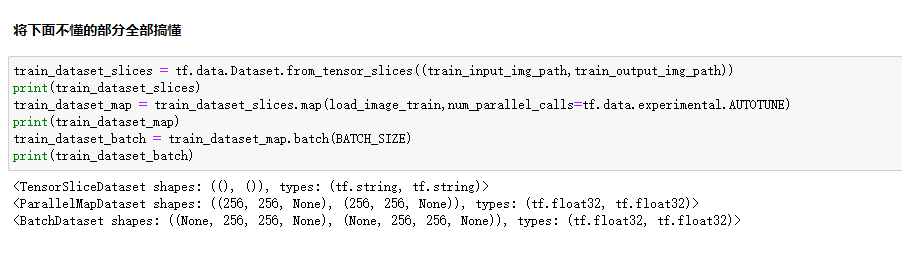
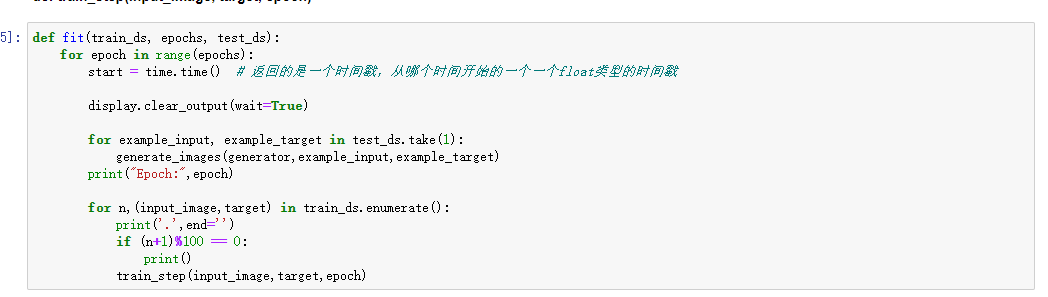

#### train_dataset.take(2) 这边的‘2’也可以换成别的数字，就是每次从这个数据集中取几组batch
#### 下面这个是两个
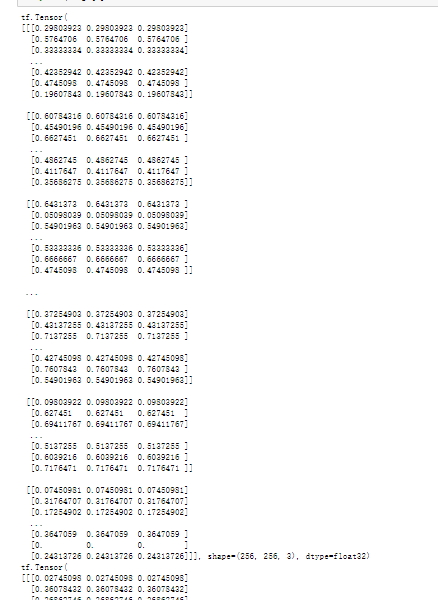

### 4、生成器

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    output = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(inputs)
    
    for layers in range(2,17,1):
        output2 = tf.keras.layers.Conv2D(64,3,padding='same',use_bias=False)(output)
        output2 = tf.keras.layers.BatchNormalization()(output2)
        output2 = tf.keras.layers.Activation('relu')(output2)
        output2 = tf.keras.layers.Conv2D(64,3,padding='same',use_bias=False)(output2)
        output2 = tf.keras.layers.BatchNormalization()(output2)
        output = output + output2
        output = tf.keras.layers.Activation('relu')(output)
        
    output = tf.keras.layers.Conv2D(1,3,padding='same')(output)
    
    output = inputs - output
    
    return tf.keras.Model(inputs=inputs, outputs=output)

#### 下面是生成器损失的函数封装

In [ ]:
''' 

计算生成器损失的参数 
PSNR  峰值信噪比  Peak Signal to Noise Ratio
SSIM  结构相似度

'''
ADVERSARIAL_LOSS_FACTOR = 0.5
PSNR_LOSS_FACTOR = -1.0
SSIM_LOSS_FACTOR = -0.1

In [ ]:
''' 

计算生成器损失 PSNR()函数

'''
def PSNR(y_true, y_pred):
    max_pixel = 255.0
    return  10.0 * tf.math.log((max_pixel ** 2) / (tf.reduce_mean(tf.square(y_pred - y_true))))/tf.math.log(10.0)

In [ ]:
''' 

计算生成器损失 _tf_fspecial_gauss()函数   作用？？？

'''

import numpy as np

def _tf_fspecial_gauss(size, sigma=1.5):
    """Function to mimic the 'fspecial' gaussian MATLAB function"""
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)

In [ ]:
''' 

计算生成器损失 SSIM_one()函数   作用？？？

'''
def SSIM_one(img1, img2, k1=0.01, k2=0.02, L=1, window_size=11):
    """
    The function is to calculate the ssim score
    """
    img1 = tf.expand_dims(img1, -1)
    img2 = tf.expand_dims(img2, -1)

    window = _tf_fspecial_gauss(window_size)

    mu1 = tf.nn.conv2d(img1, window, strides = [1, 1, 1, 1], padding = 'VALID')
    mu2 = tf.nn.conv2d(img2, window, strides = [1, 1, 1, 1], padding = 'VALID')

    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides = [1 ,1, 1, 1], padding = 'VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides = [1, 1, 1, 1], padding = 'VALID') - mu2_sq
    sigma1_2 = tf.nn.conv2d(img1*img2, window, strides = [1, 1, 1, 1], padding = 'VALID') - mu1_mu2

    c1 = (k1*L)**2
    c2 = (k2*L)**2

    ssim_map = ((2*mu1_mu2 + c1)*(2*sigma1_2 + c2)) / ((mu1_sq + mu2_sq + c1)*(sigma1_sq + sigma2_sq + c2))

    return tf.reduce_mean(ssim_map)

In [ ]:
''' 

计算生成器损失 SSIM_three()函数   作用？？？

'''
def SSIM_three(img1, img2):
    rgb1 = tf.unstack(img1, axis=3)
    r1 = rgb1[0]
    g1 = rgb1[1]
    b1 = rgb1[2]

    rgb2 = tf.unstack(img2, axis=3)
    r2 = rgb2[0]
    g2 = rgb2[1]
    b2 = rgb2[2]

    ssim_r = SSIM_one(r1, r2)
    ssim_g = SSIM_one(g1, g2)
    ssim_b = SSIM_one(b1, b2)

    ssim = tf.reduce_mean(ssim_r + ssim_g + ssim_b) / 3
    tf.print("ssim:",ssim)
    
    return ssim

#### 正式开始定义生成器的损失函数generator_loss()

In [ ]:
''' 

disc_generated_output   这个参数代表判别器对生成器输出结果的判断结果
gen_output              这个参数是生成器生成的值
target                  这个参数代表我们真实标签的值

'''
def generator_loss(disc_generated_output, gen_output, target):
    return ADVERSARIAL_LOSS_FACTOR * tf.reduce_mean(tf.scalar_mul(-1, disc_generated_output)) + \
    PSNR_LOSS_FACTOR * PSNR(target, gen_output) + SSIM_LOSS_FACTOR * SSIM_three(target, gen_output)

###  判别器

In [ ]:
''' 

自定义的判别器的激活函数和kernel初始化函数

'''
def lrelu(x):
    leak=0.2
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)

In [ ]:
def Discriminator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    output1 = tf.keras.layers.Conv2D(64,3,padding='same',strides=1,activation=lrelu)(inputs)
    output2 = tf.keras.layers.Conv2D(64,3,padding='same',strides=2,activation=lrelu)(output1)
    output3 = tf.keras.layers.Conv2D(128,3,padding='same',strides=1,activation=lrelu)(output2)
    output4 = tf.keras.layers.Conv2D(128,3,padding='same',strides=2,activation=lrelu)(output3)
    output5 = tf.keras.layers.Conv2D(256,3,padding='same',strides=1,activation=lrelu)(output4)
    output6 = tf.keras.layers.Conv2D(256,3,padding='same',strides=2,activation=lrelu)(output5)
    output7 = tf.keras.layers.Conv2D(1,3,padding='same',strides=1,activation='sigmoid')(output6)
    
    return tf.keras.Model(inputs=inputs, outputs=output7)

#### 定义我们的discriminator的损失函数

In [ ]:
''' 

disc_real_output         这个参数代表判别器对真实图像数据的判断结果
disc_generated_output    这个参数代表判别器对生成器输出结果的判断结果

'''
def discriminator_loss(disc_real_output, disc_generated_output):
    return tf.reduce_mean(disc_real_output) - tf.reduce_mean(disc_generated_output)

### 定义生成器和判别器的优化器

In [ ]:
generator_optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(LEARNING_RATE)

### 对我们的测试集测试并进行可视化

In [ ]:
def generate_images(model, test_input, target):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

### 实例化生成器和判别器模型

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
# print(generator.summary())
# print(discriminator.summary())

### 训练模型

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator(input_image, training=True)
        disc_generated_output = discriminator(gen_output, training=True)
        
        gen_loss = generator_loss(disc_generated_output,gen_output,target)
        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)
        
    tf.print('g_loss:',gen_loss,'d_loss:',disc_loss)
    
    
#     generator_gradients = gen_tape.gradient(gen_loss,generator.variables)
#     discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.variables)
    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
#     generator_optimizer.apply_gradients(zip(generator_gradients,generator.variables))
#     discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.variables))
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [ ]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()  # 返回的是一个时间戳，从哪个时间开始的一个一个float类型的时间戳
        
        display.clear_output(wait=True)
        
        for example_input, example_target in test_ds.take(1):
            generate_images(generator,example_input,example_target)
        print("Epoch:",epoch)
        
        for n,(input_image,target) in train_ds.enumerate():
            print('.',end='')
            if (n+1)%100 == 0:
                print()
            train_step(input_image,target,epoch)

### 正式训练我们的模型

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
# fit(train_dataset,EPOCHS,validation_dataset)

#### 保存我们模型

In [ ]:
import time
time = time.strftime('%Y_%m_%d_%H_%M_%S')
generator.save('generator_detectpos_{}.h5'.format(time))

### 批量处理测试集

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os

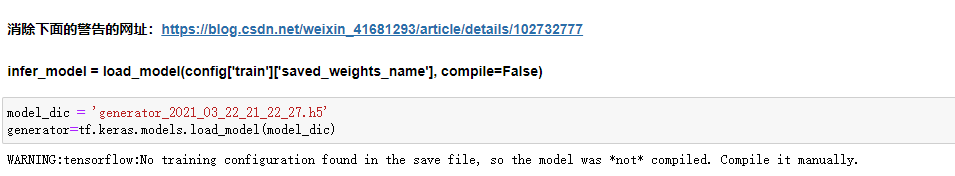

In [ ]:
image_file = './50k/'
output_image_file = './50k_dn/'
image_names = os.listdir(image_file)
image_paths = [os.path.join(image_file,name) for name in image_names]

model_path = 'generator_2021_03_22_21_22_27.h5'
generator = tf.keras.models.load_model(model_path)

for path in image_paths:
    image_input = cv2.imread(path)   # 这边返回的值是 <class 'numpy.ndarray'>类型的数据[H, W, C]   int的值
    image_input = image_input/255.0  # 这边返回的值是 <class 'numpy.ndarray'>类型的数据[H, W, C]   float的值
    image_input = tf.expand_dims(image_input, 0)  # 这边返回的类型是float64的Tensor
    # 这边是将上面的那个类型转化为float32的Tensor
    image_input = tf.cast(image_input, tf.float32)   
    # 上面的image_input输入的格式是[1,256,256,3]的float32的Tensor   是BxHxWxC的形式
    image_output = generator(image_input)[0]  # 这边得到的形式是[1,256,256,3]的float32的Tensor，这个是归一化的[0,1]
    '''
        这边自己写错了，因为上面的image_output是tensor类型的，因此我们需要的图片必须是转成numpy类型的，有两种写法。
        tensor.numpy()
        np.array(tesnsor)
    '''
    image_output = image_output.numpy()*255.0
    # 保存图片
    save_path = output_image_file + path.spile('/')[-1].spile('.')[0] + '.jpg'
    cv2.imwrite(save_path, image_output)
    
print('Finish!!!')